In [1]:
!pip install h5py pyyaml

In [10]:
import string
import re
from numpy import array, argmax, random, take
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, RepeatVector
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers
import matplotlib.pyplot as plt
import os
import tensorflow as tf
%matplotlib inline
pd.set_option('display.max_colwidth', 200)

In [11]:
# function to read raw text file
def read_text(filename):
        # open the file
        file = open("deu.txt", mode='rt', encoding='utf-8')
        
        # read all text
        text = file.read()
        file.close()
        return text


In [12]:
# split a text into sentences
def to_lines(text):
      sents = text.strip().split('\n')
      sents = [i.split('\t') for i in sents]
      return sents

In [13]:
data = read_text("deu.txt")
deu_eng = to_lines(data)
deu_eng = array(deu_eng)
deu_eng = deu_eng[:25000,:]
deu_eng

array([['Go.', 'Geh.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8597805 (Roujin)'],
       ['Hi.', 'Hallo!',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #380701 (cburgmer)'],
       ['Hi.', 'Grüß Gott!',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #659813 (Esperantostern)'],
       ...,
       ['Tom sounded tired.', 'Tom klang müde.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #4502231 (CK) & #6625452 (Felixjp)'],
       ['Tom sounded tired.', 'Tom hat müde geklungen.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #4502231 (CK) & #6625453 (Felixjp)'],
       ['Tom sounded upset.', 'Tom klang aufgebracht.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #1877549 (CK) & #6625456 (Felixjp)']],
      dtype='<U537')

In [14]:
# Remove punctuation
deu_eng[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,0]]
deu_eng[:,1] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,1]]

deu_eng

array([['Go', 'Geh',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8597805 (Roujin)'],
       ['Hi', 'Hallo',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #380701 (cburgmer)'],
       ['Hi', 'Grüß Gott',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #659813 (Esperantostern)'],
       ...,
       ['Tom sounded tired', 'Tom klang müde',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #4502231 (CK) & #6625452 (Felixjp)'],
       ['Tom sounded tired', 'Tom hat müde geklungen',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #4502231 (CK) & #6625453 (Felixjp)'],
       ['Tom sounded upset', 'Tom klang aufgebracht',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #1877549 (CK) & #6625456 (Felixjp)']],
      dtype='<U537')

In [15]:
# convert text to lowercase
for i in range(len(deu_eng)):
    deu_eng[i,0] = deu_eng[i,0].lower()
    deu_eng[i,1] = deu_eng[i,1].lower()

deu_eng

array([['go', 'geh',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8597805 (Roujin)'],
       ['hi', 'hallo',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #380701 (cburgmer)'],
       ['hi', 'grüß gott',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #659813 (Esperantostern)'],
       ...,
       ['tom sounded tired', 'tom klang müde',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #4502231 (CK) & #6625452 (Felixjp)'],
       ['tom sounded tired', 'tom hat müde geklungen',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #4502231 (CK) & #6625453 (Felixjp)'],
       ['tom sounded upset', 'tom klang aufgebracht',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #1877549 (CK) & #6625456 (Felixjp)']],
      dtype='<U537')

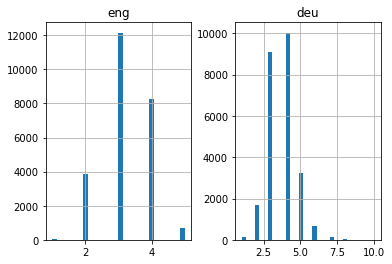

In [16]:
# empty lists
eng_l = []
deu_l = []

# populate the lists with sentence lengths
for i in deu_eng[:,0]:
      eng_l.append(len(i.split()))

for i in deu_eng[:,1]:
      deu_l.append(len(i.split()))

length_df = pd.DataFrame({'eng':eng_l, 'deu':deu_l})

length_df.hist(bins = 30)
plt.show()

In [17]:
# function to build a tokenizer
def tokenization(lines):
      tokenizer = Tokenizer()
      tokenizer.fit_on_texts(lines)
      return tokenizer

In [18]:
# prepare english tokenizer
eng_tokenizer = tokenization(deu_eng[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1

eng_length = 8
print('English Vocabulary Size: %d' % eng_vocab_size)

English Vocabulary Size: 4268


In [19]:
# prepare Deutch tokenizer
deu_tokenizer = tokenization(deu_eng[:, 1])
deu_vocab_size = len(deu_tokenizer.word_index) + 1

deu_length = 8
print('Deutch Vocabulary Size: %d' % deu_vocab_size)

Deutch Vocabulary Size: 6693


In [20]:
# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
         # integer encode sequences
         seq = tokenizer.texts_to_sequences(lines)
         # pad sequences with 0 values
         seq = pad_sequences(seq, maxlen=length, padding='post')
         return seq

In [21]:
from sklearn.model_selection import train_test_split

# split data into train and test set
train, test = train_test_split(deu_eng, test_size=0.2, random_state = 12)

In [22]:
# prepare training data
trainX = encode_sequences(deu_tokenizer, deu_length, train[:, 1])
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0])

# prepare validation data
testX = encode_sequences(deu_tokenizer, deu_length, test[:, 1])
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])

In [23]:
# build NMT model
def define_model(in_vocab,out_vocab, in_timesteps,out_timesteps,units):
      model = Sequential()
      model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
      model.add(LSTM(units))
      model.add(RepeatVector(out_timesteps))
      model.add(LSTM(units, return_sequences=True))
      model.add(Dense(out_vocab, activation='softmax'))
      return model

In [24]:
# model compilation
model = define_model(deu_vocab_size, eng_vocab_size, deu_length, eng_length, 512)
rms = optimizers.RMSprop(lr=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

In [25]:



# train model
history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1),
                    epochs=30, batch_size=512, validation_split = 0.2,
                    verbose=1)

Epoch 1/30
32/32 [==============================] - 121s 4s/step - loss: 4.6383 - val_loss: 2.5645
Epoch 2/30
32/32 [==============================] - 110s 3s/step - loss: 2.4991 - val_loss: 2.4237
Epoch 3/30
32/32 [==============================] - 110s 3s/step - loss: 2.3647 - val_loss: 2.3682
Epoch 4/30
32/32 [==============================] - 110s 3s/step - loss: 2.3033 - val_loss: 2.3009
Epoch 5/30
32/32 [==============================] - 111s 3s/step - loss: 2.1758 - val_loss: 2.2030
Epoch 6/30
32/32 [==============================] - 110s 3s/step - loss: 2.0745 - val_loss: 2.1644
Epoch 7/30
32/32 [==============================] - 112s 4s/step - loss: 1.9719 - val_loss: 2.0830
Epoch 8/30
32/32 [==============================] - 110s 3s/step - loss: 1.8869 - val_loss: 2.0415
Epoch 9/30
32/32 [==============================] - 110s 3s/step - loss: 1.8125 - val_loss: 1.9881
Epoch 10/30
32/32 [==============================] - 112s 4s/step - loss: 1.7301 - val_loss: 1.9329
Epoch 11/

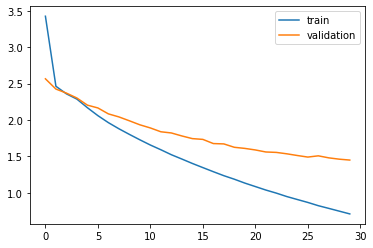

In [26]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

In [29]:
def get_word(n, tokenizer):
      for word, index in tokenizer.word_index.items():
          if index == n:
              return word
      return None

In [34]:
model.evaluate(testX, testY, batch_size=512)

10/10 [==============================] - 13s 1s/step - loss: 1.4393


1.4392874240875244

In [35]:
model.evaluate(trainX, trainY, batch_size=512)

40/40 [==============================] - 46s 1s/step - loss: 0.8109


0.8109166026115417

In [38]:
import time
t = time.time()
export_path_keras = "./{}.h5".format(int(t))
print(export_path_keras)

model.save(export_path_keras)


./1617184732.h5
